<a href="https://colab.research.google.com/github/jinunyachhyon/Vision-Transformer-ViT-/blob/main/Vision_Transformer_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Hyperparameter Definitions

In [1]:
import torch
from torch import nn

In [2]:
import pandas as pd
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

In [3]:
import random
import timeit
from tqdm import tqdm
from torch import optim

In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [5]:
LEARNING_RATE = 1e-4
NUM_CLASSES = 10                              # For MNIST dataset classes 0 to 9
PATCH_SIZE = 4                                # Each Patch = (4 x 4 x no. of channels)
IMG_SIZE = 28                                 # Each Image = (28 x 28 x 1)
IN_CHANNELS = 1                               # For the MNIST dataset, it is black and white, so only 1 channel
NUM_HEADS = 8                                 # For Multi-head attention, 8 heads: Each head dim = EMBED_DIM/NUM_HEADS
DROPOUT = 0.001
HIDDEN_DIM = 768                              # For feed-forward network
ADAM_WEIGHT_DECAY = 0
ADAM_BETAS = (0.9, 0.999)
ACTIVATION = "gelu"
NUM_ENCODERS = 4                              # Stacking 4 transformer encoders
EMBED_DIM = (PATCH_SIZE ** 2) * IN_CHANNELS   # 16 -- Patch Embedding (4x4x16)
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2   # 49

device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
RANDOM_SEED = 42
BATCH_SIZE = 512
EPOCHS = 40

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ViT Model (BareBone Initialization)

## Patch Embedding Implementation

### How the Original ViT Works (Without Conv2D):

In the original Vision Transformer paper:
1. The input image is **224x224x3** (RGB).
2. The image is divided into non-overlapping **16x16 patches**, so there are **14x14 = 196 patches** in total.
3. Each **16x16x3 patch** is **flattened** into a **1D vector** of size \(16 \times 16 \times 3 = 768\).
4. This **768-dimensional vector** is then linearly projected (via a fully connected layer) into the same or higher dimensional space (in the base model, it's kept at 768).
5. The resulting sequence of **196 patch embeddings** (each of size 768) is fed into the transformer.



### In Practice:

- Some models like **"Hybrid ViTs"** actually use **ConvNets as a feature extractor** before passing the features to the transformer. These models combine the strengths of **CNNs (local feature extraction)** and **transformers (global attention)**.

- In the case of our Conv2D configuration:

  - **Kernel Size**: \(4\)
  - **Stride**: \(4\)
  - **Input Channels**: \(1\) (since it's a grayscale image, as in MNIST)
  - **Output Channels**: \(16\)

### Conv2D Output Shape and Patch Size:

1. **Patch Size of 4x4x16**:
   - The **Conv2D layer** is using a **kernel size of \(4 x 4\)** with a **stride of 4**, so it is effectively dividing the input image into **non-overlapping patches** of size \(4 x 4\).
   - Each of these \(4 x 4\) patches is processed independently to produce **16 feature maps (channels)** per patch (since the output channels = 16).

2. **Conv2D Output Calculation**:
   - The input image size is \(28 x 28\).
   - Using the Conv2D formula for the output size:

  $
  \text{Output Size} = \frac{\text{Input Size} - \text{Kernel Size} + \text {2 x Padding}}{\text{Stride}} + 1
  $

  For both height and width:

  $
  \text{Output Size} = \frac{28 - 4}{4} + 1 = \frac{24}{4} + 1 = 6 + 1 = 7
  $

  Thus, the Conv2D layer breaks the image into **7x7 grid of 16-dimensional feature vectors**.

### nn.Flatten(start_dim=2):

- The **`Flatten(start_dim=2)`** layer flattens the output starting from the second dimension. In other words, it combines the spatial dimensions (height and width) of the feature map into a single dimension.
  
- The output shape after **Conv2D** is **(Batch Size, embed_dim, 7, 7)**, representing the number of patches and their embeddings.

- **`Flatten(start_dim=2)`** flattens the last two dimensions (7, 7), making the output:
  $
  (\text{Batch Size}, \text{embed_dim}, 7 \times 7) = (\text{Batch Size}, \text{embed_dim}, 49)
  $

- The output dimension of our patcher having a shape of (1, 16, 49) implies that:

  49 patches were created from the input image. Each patch has been embedded into a 16-dimensional vector.

### [CLS] Token

Each patch is transformed into a vector of size `embed_dim` (e.g., `16-dimensional`), and the `[CLS]` token must also have the same dimensionality (i.e., `16-dimensional` in this case) so that it can be concatenated with the patch embeddings.

Here’s why:

- The self-attention mechanism in the Vision Transformer (ViT) operates on a sequence of tokens where **each token must have the same embedding dimension**. This ensures that the `[CLS]` token can participate equally with the patch tokens during the self-attention computation.
  
- The `[CLS]` token's purpose is to aggregate information across all patches, so it needs to be in the same space (i.e., same dimensionality) as the patch embeddings. If each patch is represented by a `16-dimensional` vector, the `[CLS]` token must also be a `16-dimensional` vector.

For instance:
- Each patch embedding: `[batch_size, num_patches, embed_dim]` = `[batch_size, 49, 16]` (assuming `49` patches and `embed_dim=16`)
- `[CLS]` token: `[batch_size, 1, embed_dim]` = `[batch_size, 1, 16]`
- After concatenation: `[batch_size, num_patches + 1, embed_dim]` = `[batch_size, 50, 16]`

This uniform dimension allows the transformer to process the `[CLS]` token and patch embeddings together.

In [7]:
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()

        # Create patches of (Patch size x Patch size) in the image of (Img size x Img size) with Embed-dim feature vectors
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size,
            ),
            nn.Flatten(start_dim=2)
        )

        # [CLS] token initialization
        self.cls_token = nn.Parameter(torch.randn(size=(1, 1, embed_dim)), requires_grad=True)

        # Position Embedding
        self.pos_embeddings = nn.Parameter(torch.randn(size=(1, num_patches + 1, embed_dim)), requires_grad=True)

        # Dropout
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        x = self.patcher(x).permute(0, 2, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = self.pos_embeddings + x
        x = self.dropout(x)
        return x

In [8]:
# Test Patch Embedding
test_PatchEmbedding = PatchEmbedding(
    embed_dim=EMBED_DIM,
    patch_size=PATCH_SIZE,
    num_patches=NUM_PATCHES,
    dropout=DROPOUT,
    in_channels=IN_CHANNELS
).to(device)

x = torch.randn(1, 1, 28, 28).to(device)
print(test_PatchEmbedding(x).shape)

torch.Size([1, 50, 16])


## Vision Transformer (ViT)

In [9]:
class ViT(nn.Module):
    def __init__(self, num_patches, num_classes, patch_size, embed_dim, num_encoders, num_heads, hidden_dim, dropout, activation, in_channels):
        super().__init__()

        # Patch Embedding (Patch + Position)
        self.embeddings_block = PatchEmbedding(
            embed_dim=embed_dim,
            patch_size=patch_size,
            num_patches=num_patches,
            dropout=dropout,
            in_channels=in_channels
        )

        # Encoder Layer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            dropout=dropout,
            activation=activation,
            batch_first=True,
            norm_first=True
        )

        # Transformer Encoder
        self.encoder_block = nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=num_encoders,
        )

        # MLP Head (Classification Layer)
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes)
        )

    def forward(self, x):
        x = self.embeddings_block(x)
        x = self.encoder_block(x)
        x = self.mlp_head(x[:, 0, :])
        return x

In [10]:
# Test Vit model
model = ViT(num_patches = NUM_PATCHES,
            num_classes = NUM_CLASSES,
            patch_size = PATCH_SIZE,
            embed_dim = EMBED_DIM,
            num_encoders = NUM_ENCODERS,
            num_heads = NUM_HEADS,
            hidden_dim = HIDDEN_DIM,
            dropout = DROPOUT,
            activation = ACTIVATION,
            in_channels = IN_CHANNELS).to(device)

x = torch.randn(1, 1, 28, 28).to(device)
print(model(x).shape)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


torch.Size([1, 10])


# Data Preparation (MNIST)

In [11]:
# Image Preprocessing and Augumentation
train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [12]:
# Download the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=test_transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5072831.09it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 133983.65it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1263518.99it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4248556.82it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [13]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )

In [14]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )

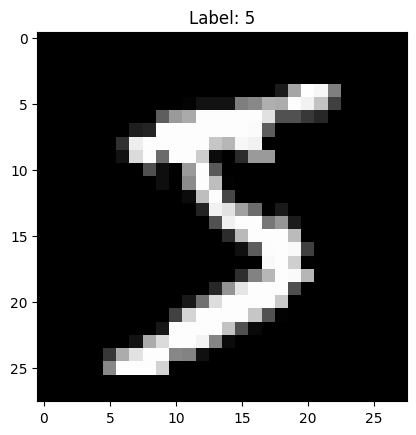

In [15]:
# Visualize the dataset
img, label = train_dataset[0]
plt.imshow(img.squeeze(), cmap='gray')
plt.title(f"Label: {label}")
plt.show()

In [16]:
# Create data loaders to easily iterate over the dataset
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [17]:
# Example
for idx, batch in enumerate(train_loader):
    print(batch[0].shape)
    print(batch[1].shape)
    break

torch.Size([512, 1, 28, 28])
torch.Size([512])


# Training Loop

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)

start = timeit.default_timer()
for epoch in tqdm(range(EPOCHS), position=0, leave=True):
    # Training
    model.train()
    train_labels = []
    train_preds = []
    train_running_loss = 0

    for idx, img_label in enumerate(tqdm(train_loader, position=0, leave=True)):
        img = img_label[0].to(device)
        label = img_label[1].to(device)
        y_pred = model(img)
        y_pred_label = torch.argmax(y_pred, dim=1)

        train_labels.extend(label.cpu().detach())
        train_preds.extend(y_pred_label.cpu().detach())

        loss = criterion(y_pred, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
    train_loss = train_running_loss / (idx + 1)

    # Evaluation
    model.eval()
    val_labels = []
    val_preds = []
    val_running_loss = 0
    with torch.no_grad():
        for idx, img_label in enumerate(tqdm(test_loader, position=0, leave=True)):
            img = img_label[0].to(device)
            label = img_label[1].to(device)
            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)

            val_labels.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())

            loss = criterion(y_pred, label)
            val_running_loss += loss.item()
    val_loss = val_running_loss / (idx + 1)

    print("-"*30)
    print(f"Train Loss EPOCH {epoch+1}: {train_loss:.4f}")
    print(f"Valid Loss EPOCH {epoch+1}: {val_loss:.4f}")
    print(f"Train Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(train_preds, train_labels) if x == y) / len(train_labels):.4f}")
    print(f"Valid Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(val_preds, val_labels) if x == y) / len(val_labels):.4f}")
    print("-"*30)

stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")

100%|██████████| 20/20 [00:02<00:00,  7.33it/s]


------------------------------
Train Loss EPOCH 1: 2.2279
Valid Loss EPOCH 1: 1.9386


  2%|▎         | 1/40 [00:36<23:39, 36.39s/it]

Train Accuracy EPOCH 1: 0.1788
Valid Accuracy EPOCH 1: 0.3448
------------------------------


100%|██████████| 20/20 [00:03<00:00,  5.54it/s]


------------------------------
Train Loss EPOCH 2: 1.7239
Valid Loss EPOCH 2: 1.5526


  5%|▌         | 2/40 [01:10<22:11, 35.04s/it]

Train Accuracy EPOCH 2: 0.4365
Valid Accuracy EPOCH 2: 0.5057
------------------------------


100%|██████████| 20/20 [00:03<00:00,  6.25it/s]


------------------------------
Train Loss EPOCH 3: 1.4725
Valid Loss EPOCH 3: 1.3221


  8%|▊         | 3/40 [01:48<22:22, 36.30s/it]

Train Accuracy EPOCH 3: 0.5566
Valid Accuracy EPOCH 3: 0.6181
------------------------------


100%|██████████| 20/20 [00:02<00:00,  7.62it/s]


------------------------------
Train Loss EPOCH 4: 1.2928
Valid Loss EPOCH 4: 1.1147


 10%|█         | 4/40 [02:22<21:11, 35.32s/it]

Train Accuracy EPOCH 4: 0.6272
Valid Accuracy EPOCH 4: 0.7064
------------------------------


100%|██████████| 20/20 [00:02<00:00,  7.53it/s]


------------------------------
Train Loss EPOCH 5: 1.1523
Valid Loss EPOCH 5: 0.9859


 12%|█▎        | 5/40 [02:56<20:24, 34.99s/it]

Train Accuracy EPOCH 5: 0.6752
Valid Accuracy EPOCH 5: 0.7495
------------------------------


100%|██████████| 20/20 [00:03<00:00,  5.80it/s]


------------------------------
Train Loss EPOCH 6: 1.0379
Valid Loss EPOCH 6: 0.8887


 15%|█▌        | 6/40 [03:31<19:47, 34.93s/it]

Train Accuracy EPOCH 6: 0.7144
Valid Accuracy EPOCH 6: 0.7695
------------------------------


100%|██████████| 20/20 [00:02<00:00,  7.66it/s]


------------------------------
Train Loss EPOCH 7: 0.9491
Valid Loss EPOCH 7: 0.8046


 18%|█▊        | 7/40 [04:05<19:05, 34.72s/it]

Train Accuracy EPOCH 7: 0.7406
Valid Accuracy EPOCH 7: 0.7920
------------------------------


100%|██████████| 20/20 [00:02<00:00,  7.51it/s]


------------------------------
Train Loss EPOCH 8: 0.8637
Valid Loss EPOCH 8: 0.7316


 20%|██        | 8/40 [04:40<18:29, 34.68s/it]

Train Accuracy EPOCH 8: 0.7652
Valid Accuracy EPOCH 8: 0.8160
------------------------------


100%|██████████| 20/20 [00:03<00:00,  6.60it/s]


------------------------------
Train Loss EPOCH 9: 0.7937
Valid Loss EPOCH 9: 0.6533


 22%|██▎       | 9/40 [05:15<17:59, 34.83s/it]

Train Accuracy EPOCH 9: 0.7840
Valid Accuracy EPOCH 9: 0.8403
------------------------------


100%|██████████| 20/20 [00:02<00:00,  6.75it/s]


------------------------------
Train Loss EPOCH 10: 0.7394
Valid Loss EPOCH 10: 0.5990


 25%|██▌       | 10/40 [05:50<17:23, 34.80s/it]

Train Accuracy EPOCH 10: 0.7986
Valid Accuracy EPOCH 10: 0.8493
------------------------------


100%|██████████| 20/20 [00:02<00:00,  7.45it/s]


------------------------------
Train Loss EPOCH 11: 0.6707
Valid Loss EPOCH 11: 0.6573


 28%|██▊       | 11/40 [06:24<16:48, 34.76s/it]

Train Accuracy EPOCH 11: 0.8195
Valid Accuracy EPOCH 11: 0.8207
------------------------------


100%|██████████| 20/20 [00:02<00:00,  7.39it/s]


------------------------------
Train Loss EPOCH 12: 0.6293
Valid Loss EPOCH 12: 0.5237


 30%|███       | 12/40 [06:59<16:15, 34.83s/it]

Train Accuracy EPOCH 12: 0.8291
Valid Accuracy EPOCH 12: 0.8704
------------------------------


100%|██████████| 20/20 [00:03<00:00,  5.78it/s]


------------------------------
Train Loss EPOCH 13: 0.5789
Valid Loss EPOCH 13: 0.4640


 32%|███▎      | 13/40 [07:34<15:36, 34.69s/it]

Train Accuracy EPOCH 13: 0.8423
Valid Accuracy EPOCH 13: 0.8841
------------------------------


100%|██████████| 20/20 [00:02<00:00,  7.38it/s]


------------------------------
Train Loss EPOCH 14: 0.5481
Valid Loss EPOCH 14: 0.4357


 35%|███▌      | 14/40 [08:08<14:56, 34.46s/it]

Train Accuracy EPOCH 14: 0.8496
Valid Accuracy EPOCH 14: 0.8913
------------------------------


100%|██████████| 20/20 [00:02<00:00,  7.38it/s]


------------------------------
Train Loss EPOCH 15: 0.5128
Valid Loss EPOCH 15: 0.4133


 38%|███▊      | 15/40 [08:43<14:27, 34.70s/it]

Train Accuracy EPOCH 15: 0.8579
Valid Accuracy EPOCH 15: 0.8953
------------------------------


100%|██████████| 20/20 [00:02<00:00,  6.83it/s]


------------------------------
Train Loss EPOCH 16: 0.4889
Valid Loss EPOCH 16: 0.3912


 40%|████      | 16/40 [09:17<13:50, 34.61s/it]

Train Accuracy EPOCH 16: 0.8638
Valid Accuracy EPOCH 16: 0.8981
------------------------------


100%|██████████| 20/20 [00:02<00:00,  6.71it/s]


------------------------------
Train Loss EPOCH 17: 0.4646
Valid Loss EPOCH 17: 0.3943


 42%|████▎     | 17/40 [09:52<13:15, 34.57s/it]

Train Accuracy EPOCH 17: 0.8697
Valid Accuracy EPOCH 17: 0.8945
------------------------------


100%|██████████| 20/20 [00:02<00:00,  7.82it/s]


------------------------------
Train Loss EPOCH 18: 0.4450
Valid Loss EPOCH 18: 0.3644


 45%|████▌     | 18/40 [10:25<12:35, 34.34s/it]

Train Accuracy EPOCH 18: 0.8740
Valid Accuracy EPOCH 18: 0.8996
------------------------------


100%|██████████| 20/20 [00:02<00:00,  7.04it/s]


------------------------------
Train Loss EPOCH 19: 0.4200
Valid Loss EPOCH 19: 0.3340


 48%|████▊     | 19/40 [10:59<11:58, 34.21s/it]

Train Accuracy EPOCH 19: 0.8805
Valid Accuracy EPOCH 19: 0.9095
------------------------------


100%|██████████| 20/20 [00:02<00:00,  7.67it/s]


------------------------------
Train Loss EPOCH 20: 0.4021
Valid Loss EPOCH 20: 0.3225


 50%|█████     | 20/40 [11:33<11:18, 33.93s/it]

Train Accuracy EPOCH 20: 0.8854
Valid Accuracy EPOCH 20: 0.9122
------------------------------


100%|██████████| 20/20 [00:02<00:00,  7.20it/s]


------------------------------
Train Loss EPOCH 21: 0.3886
Valid Loss EPOCH 21: 0.2994


 52%|█████▎    | 21/40 [12:07<10:45, 33.98s/it]

Train Accuracy EPOCH 21: 0.8880
Valid Accuracy EPOCH 21: 0.9176
------------------------------


100%|██████████| 20/20 [00:02<00:00,  6.88it/s]


------------------------------
Train Loss EPOCH 22: 0.3697
Valid Loss EPOCH 22: 0.2806


 55%|█████▌    | 22/40 [12:40<10:09, 33.89s/it]

Train Accuracy EPOCH 22: 0.8923
Valid Accuracy EPOCH 22: 0.9238
------------------------------


100%|██████████| 20/20 [00:02<00:00,  7.58it/s]


------------------------------
Train Loss EPOCH 23: 0.3575
Valid Loss EPOCH 23: 0.2711


 57%|█████▊    | 23/40 [13:14<09:34, 33.79s/it]

Train Accuracy EPOCH 23: 0.8963
Valid Accuracy EPOCH 23: 0.9264
------------------------------


100%|██████████| 20/20 [00:02<00:00,  7.42it/s]


------------------------------
Train Loss EPOCH 24: 0.3424
Valid Loss EPOCH 24: 0.2833


 60%|██████    | 24/40 [13:48<09:01, 33.87s/it]

Train Accuracy EPOCH 24: 0.9005
Valid Accuracy EPOCH 24: 0.9173
------------------------------


100%|██████████| 20/20 [00:03<00:00,  6.42it/s]


------------------------------
Train Loss EPOCH 25: 0.3324
Valid Loss EPOCH 25: 0.2535


 62%|██████▎   | 25/40 [14:22<08:27, 33.82s/it]

Train Accuracy EPOCH 25: 0.9022
Valid Accuracy EPOCH 25: 0.9300
------------------------------


100%|██████████| 20/20 [00:02<00:00,  7.69it/s]


------------------------------
Train Loss EPOCH 26: 0.3183
Valid Loss EPOCH 26: 0.2557


 65%|██████▌   | 26/40 [14:55<07:50, 33.58s/it]

Train Accuracy EPOCH 26: 0.9064
Valid Accuracy EPOCH 26: 0.9253
------------------------------


100%|██████████| 20/20 [00:02<00:00,  7.51it/s]


------------------------------
Train Loss EPOCH 27: 0.3124
Valid Loss EPOCH 27: 0.2363


 68%|██████▊   | 27/40 [15:29<07:18, 33.77s/it]

Train Accuracy EPOCH 27: 0.9074
Valid Accuracy EPOCH 27: 0.9349
------------------------------


100%|██████████| 20/20 [00:03<00:00,  6.16it/s]


------------------------------
Train Loss EPOCH 28: 0.3023
Valid Loss EPOCH 28: 0.2348


 70%|███████   | 28/40 [16:03<06:45, 33.80s/it]

Train Accuracy EPOCH 28: 0.9096
Valid Accuracy EPOCH 28: 0.9304
------------------------------


100%|██████████| 20/20 [00:02<00:00,  7.03it/s]


------------------------------
Train Loss EPOCH 29: 0.2993
Valid Loss EPOCH 29: 0.2216


 72%|███████▎  | 29/40 [16:36<06:09, 33.62s/it]

Train Accuracy EPOCH 29: 0.9107
Valid Accuracy EPOCH 29: 0.9364
------------------------------


100%|██████████| 20/20 [00:02<00:00,  7.75it/s]


------------------------------
Train Loss EPOCH 30: 0.2900
Valid Loss EPOCH 30: 0.2439


 75%|███████▌  | 30/40 [17:10<05:36, 33.67s/it]

Train Accuracy EPOCH 30: 0.9121
Valid Accuracy EPOCH 30: 0.9269
------------------------------


100%|██████████| 20/20 [00:03<00:00,  6.13it/s]


------------------------------
Train Loss EPOCH 31: 0.2900
Valid Loss EPOCH 31: 0.2163


 78%|███████▊  | 31/40 [17:44<05:04, 33.81s/it]

Train Accuracy EPOCH 31: 0.9132
Valid Accuracy EPOCH 31: 0.9372
------------------------------


100%|██████████| 20/20 [00:02<00:00,  7.58it/s]


------------------------------
Train Loss EPOCH 32: 0.2733
Valid Loss EPOCH 32: 0.2007


 80%|████████  | 32/40 [18:17<04:29, 33.68s/it]

Train Accuracy EPOCH 32: 0.9173
Valid Accuracy EPOCH 32: 0.9423
------------------------------


100%|██████████| 20/20 [00:02<00:00,  7.51it/s]


------------------------------
Train Loss EPOCH 33: 0.2660
Valid Loss EPOCH 33: 0.2074


 82%|████████▎ | 33/40 [18:51<03:56, 33.80s/it]

Train Accuracy EPOCH 33: 0.9190
Valid Accuracy EPOCH 33: 0.9401
------------------------------


100%|██████████| 20/20 [00:03<00:00,  5.45it/s]


------------------------------
Train Loss EPOCH 34: 0.2617
Valid Loss EPOCH 34: 0.2070


 85%|████████▌ | 34/40 [19:26<03:23, 33.89s/it]

Train Accuracy EPOCH 34: 0.9195
Valid Accuracy EPOCH 34: 0.9400
------------------------------


100%|██████████| 20/20 [00:02<00:00,  7.75it/s]


------------------------------
Train Loss EPOCH 35: 0.2621
Valid Loss EPOCH 35: 0.2014


 88%|████████▊ | 35/40 [20:00<02:49, 33.96s/it]

Train Accuracy EPOCH 35: 0.9201
Valid Accuracy EPOCH 35: 0.9425
------------------------------


100%|██████████| 20/20 [00:04<00:00,  4.63it/s]


------------------------------
Train Loss EPOCH 36: 0.2520
Valid Loss EPOCH 36: 0.1878


 90%|█████████ | 36/40 [20:38<02:21, 35.36s/it]

Train Accuracy EPOCH 36: 0.9237
Valid Accuracy EPOCH 36: 0.9436
------------------------------


100%|██████████| 20/20 [00:02<00:00,  6.70it/s]


------------------------------
Train Loss EPOCH 37: 0.2492
Valid Loss EPOCH 37: 0.1848


 92%|█████████▎| 37/40 [21:17<01:49, 36.51s/it]

Train Accuracy EPOCH 37: 0.9241
Valid Accuracy EPOCH 37: 0.9475
------------------------------


100%|██████████| 20/20 [00:03<00:00,  6.36it/s]


------------------------------
Train Loss EPOCH 38: 0.2440
Valid Loss EPOCH 38: 0.2123


 95%|█████████▌| 38/40 [21:59<01:15, 37.86s/it]

Train Accuracy EPOCH 38: 0.9254
Valid Accuracy EPOCH 38: 0.9353
------------------------------


100%|██████████| 20/20 [00:03<00:00,  6.40it/s]


------------------------------
Train Loss EPOCH 39: 0.2341
Valid Loss EPOCH 39: 0.1839


 98%|█████████▊| 39/40 [22:38<00:38, 38.30s/it]

Train Accuracy EPOCH 39: 0.9287
Valid Accuracy EPOCH 39: 0.9440
------------------------------


100%|██████████| 20/20 [00:02<00:00,  7.16it/s]


------------------------------
Train Loss EPOCH 40: 0.2291
Valid Loss EPOCH 40: 0.1809


100%|██████████| 40/40 [23:13<00:00, 34.84s/it]

Train Accuracy EPOCH 40: 0.9299
Valid Accuracy EPOCH 40: 0.9472
------------------------------
Training Time: 1393.56s


In [19]:
torch.cuda.empty_cache()

# Inference

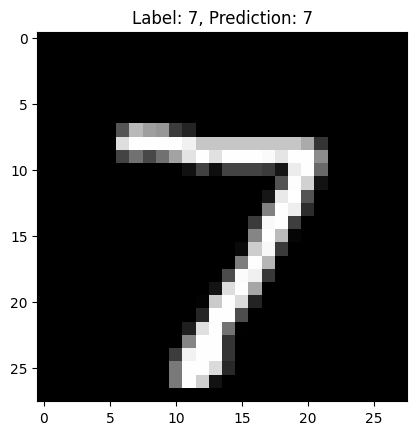

In [20]:
img, label = test_dataset[0]

# Inference
model.eval()
with torch.no_grad():
    img = img.unsqueeze(0).to(device)
    y_pred = model(img)
    y_pred_label = torch.argmax(y_pred, dim=1)

# Visualize
plt.imshow(img.squeeze().cpu().detach(), cmap='gray')
plt.title(f"Label: {label}, Prediction: {y_pred_label.item()}")
plt.show()

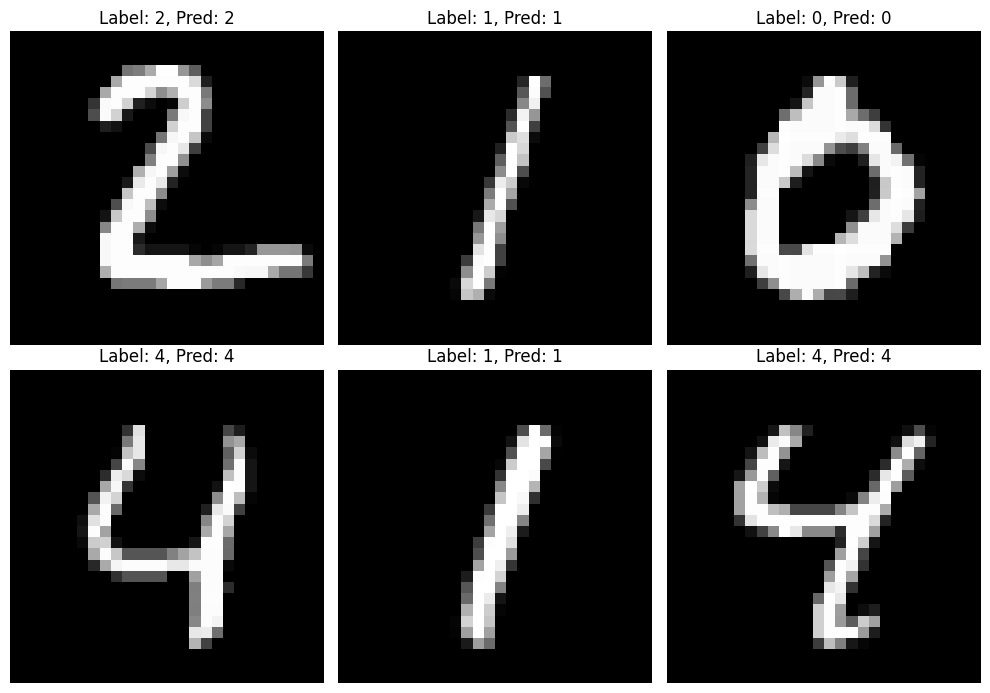

In [21]:
# Let's inference for 6 images
model.eval()

# Set up the plot
fig, axs = plt.subplots(2, 3, figsize=(10, 7))  # Create a 2x3 grid for 6 images

# Loop through 6 images in the test dataset
for i in range(6):
    img, label = test_dataset[i+1]  # Get the i-th image and its label

    # Inference
    with torch.no_grad():
        img_input = img.unsqueeze(0).to(device)  # Add batch dimension and move to device (e.g., GPU)
        y_pred = model(img_input)  # Make prediction
        y_pred_label = torch.argmax(y_pred, dim=1)  # Get predicted label

    # Plot the image in the grid
    ax = axs[i // 3, i % 3]  # Subplot index management
    ax.imshow(img.squeeze().cpu().detach(), cmap='gray')  # Show image in grayscale
    ax.set_title(f"Label: {label}, Pred: {y_pred_label.item()}")
    ax.axis('off')  # Turn off the axis labels

# Adjust layout so the titles and images don't overlap
plt.tight_layout()
plt.show()

We successfully built a Vision Transformer (ViT) from scratch and trained it for 40 epochs. The model achieved a training accuracy of 92.99% and a validation accuracy of 94.72%. After making several inferences, we observed that the model predicted all samples correctly, indicating that it is well-trained and generalizes effectively on unseen data.

# References

1. **Dosovitskiy, A., et al.** (2020). *An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale*. arXiv. Available at: [https://arxiv.org/abs/2010.11929](https://arxiv.org/abs/2010.11929)

2. **Video Implementation** (2023). *Implement and Train ViT From Scratch for Image Recognition - PyTorch*. YouTube. Available at: [https://youtu.be/Vonyoz6Yt9c?si=jquplbntSfNrhrJU](https://youtu.be/Vonyoz6Yt9c?si=jquplbntSfNrhrJU)

3. **Kurt, U.** (2023). *ViT-PyTorch: A PyTorch Implementation of Vision Transformers*. GitHub repository. Available at: [https://github.com/uygarkurt/ViT-PyTorch](https://github.com/uygarkurt/ViT-PyTorch)
